# 3.1 线性回归基础

## 一、基础知识

#### 房价预测简化模型
- 假设1：有三个变量$x_1,x_2,x_3$是关键因素影响房价
- 假设2：成交价是关键因素的加权和

    $y=w_1x_1+w_2x_2+w_3x_3+b$

- 目标：求出参数**w**和b

#### 线性模型
1. 输入 **x**=$[x_1,x_2,…,x_n]^T$
2. 参数 
    - n维权重 **w**=$[w_1,w_2,…,w_n]^T$
    - 标量b
3. 输出 $y=w_1x_1+w_2x_2+…+w_nx_n+b$
    即 $y=$**w**·**x**$+b$

#### 偏差
- 用于比较真实值和预估值的差距
- 平方损失

#### 训练数据
- 根据某些已知数据（训练数据）得到参数值（权重**w**和偏差b）
- 越多越好
- n个训练数据（样本）
    - **X** = [**x$_1$,x$_2$,…,x$_n$**]$^T$
    - **y** = [$y_1,y_2,…,y_n$]$^T$
    - **X**是所有输入的集合，每一行是一个输入向量
    - **y**是所有输出的集合，每个值是一个输出标量

#### 模型
- 训练得到损失函数
- 最小化损失以学习参数
- 可以将**X**增加一列（每个输入增加一个1），**w**增加一个值b，将参数省略为**w**
- 线性模型可以求出显式解

#### 基础优化-小批量随机梯度下降
- 目的：在没有显示解时更新权重参数
- 方法：小批量随机梯度下降
    1. 挑选一个初始值$w_0$
    2. 挑选一个学习率η和迭代次数
    3. 沿着梯度减少的方向降低损失函数，求解下一个$w_n$

#### 小批量随机梯度下降优化的超参数
1. 学习率η：不能太长(走过)也不能太短(太慢)
2. 小批量b：不能太大(内存瓶颈+浪费计算)也不能太小(不准确+资源利用率低)
    - 通常不是整个训练集**X**而是训练集的一个小部分
    - 随机选择b个样本 [**x**$_1$, **x**$_2$,…,**x**$_b$] 求解损失

## 二、从零开始实现

导包

In [2]:
%matplotlib inline
import random  #用于随机梯度下降和随机初始化参数
import torch
from d2l import torch as d2l  # 常用地相关函数

#### 数据准备：构造人造数据集
根据人造参数w, b, 噪声生成一系列的数据集X和标签y

In [3]:
# 给定参数w,b,样本数量n
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [4]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [5]:
# 查看训练样本
print('features:\n', features[0:10], '\nlabels:\n', labels[0:10])

features:
 tensor([[ 0.3646, -0.8910],
        [-0.1543,  0.3280],
        [ 0.5286, -0.7841],
        [-0.0774, -1.8123],
        [-0.0130,  0.5989],
        [ 2.0604,  0.6712],
        [-0.0975,  1.1655],
        [ 0.1578, -2.7130],
        [-1.1337, -0.1138],
        [-0.9631, -0.7423]]) 
labels:
 tensor([[ 7.9452],
        [ 2.7658],
        [ 7.9268],
        [10.2132],
        [ 2.1265],
        [ 6.0143],
        [ 0.0161],
        [13.7310],
        [ 2.3303],
        [ 4.7903]])


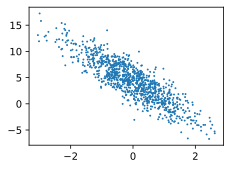

In [6]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1);

#### 数据准备：生成小批量
根据所有样本和批量大小生成一个小批量

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))  #将样本编号
    random.shuffle(indices)  #打乱样本序号

    # 使用乱序样本序号依次读取批量大小
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])  #确定某个批量的序号
        yield features[batch_indices], labels[batch_indices]  #迭代器，每次调用每次返回

In [8]:
batch_size = 10
for (X, y) in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 2.3325, -0.1236],
        [ 0.1132,  1.1613],
        [ 0.0330,  1.6162],
        [-0.3815,  0.9781],
        [-0.4848,  0.9249],
        [-1.1333, -0.5631],
        [ 0.2777,  1.1103],
        [ 1.4116,  0.2274],
        [-1.3436,  0.0442],
        [ 0.3646, -0.8910]]) 
 tensor([[ 9.2716],
        [ 0.4818],
        [-1.2161],
        [ 0.1214],
        [ 0.0841],
        [ 3.8420],
        [ 0.9819],
        [ 6.2495],
        [ 1.3730],
        [ 7.9452]])


#### 模型

1.初始化模型参数

In [27]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

2.定义模型

In [11]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

3.定义损失函数

In [12]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

4.定义优化算法

In [15]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

#### 训练

In [28]:
lr = 0.03  #学习率
num_epochs = 10  #训练次数(将整个样本训练几次)
net = linreg
loss = squared_loss

# 两次循环：
# 1.整个样本扫 
# 2.按照小批量求梯度
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  #求一次损失
        l.sum().backward()  #反向传递
        sgd([w, b], lr, batch_size)  #更新参数
    # 整个样本扫描了一次，看看结果
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1},loss {train_l.mean().item():.5f}')

epoch 1,loss 0.03091
epoch 2,loss 0.00010
epoch 3,loss 0.00005
epoch 4,loss 0.00005
epoch 5,loss 0.00005
epoch 6,loss 0.00005
epoch 7,loss 0.00005
epoch 8,loss 0.00005
epoch 9,loss 0.00005
epoch 10,loss 0.00005
